<a href="https://colab.research.google.com/github/hicassey/wodusdl/blob/master/%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%82%AC%EC%9D%B4%EC%96%B8%EC%8A%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available")


GPU is available: NVIDIA A100-SXM4-40GB


In [ ]:
import torch
import torch.nn as nn
import sys
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch.nn.init as init
def load_data(file_path):
    return pd.read_csv(file_path)

def preprocess_data(df):

    # 금액이 0보다 큰 값만 남김
    df = df[df['Amount'] > 0]

    # 날짜 변환
    df['Acct Open Date'] = pd.to_datetime(df['Acct Open Date'], errors='coerce')
    df['Expires'] = pd.to_datetime(df['Expires'], errors='coerce')
    df['Acct Open Date'] = pd.to_datetime(df['Acct Open Date'], format='%Y-%m-%d', errors='coerce')
    df['Expires'] = pd.to_datetime(df['Expires'], format='%Y-%m-%d', errors='coerce')
    df['Birth Date'] = pd.to_datetime(df['Birth Year'].astype(str) + '-' + df['Birth Month'].astype(str) + '-01')
    df.drop(['Birth Year', 'Birth Month'], axis=1, inplace=True)
    df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-' + df['Day'].astype(str))
    df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)
    df['Year PIN last Changed'] = pd.to_datetime(df['Year PIN last Changed'].astype(str) + '-01-01')

    # 날짜 차이 계산 및 datetime 열 삭제
    datetime_columns = ['Expires', 'Acct Open Date', 'Year PIN last Changed', 'Birth Date']
    for col in datetime_columns:
        df[f'Days Until {col}'] = (df['Date'] - df[col]).dt.days

    # 원래 datetime 변수들 삭제
    df.drop(datetime_columns, axis=1, inplace=True)
    df.drop('Date', axis=1, inplace=True)

    # 신용 점수 기준에 따라 등급을 부여하는 함수 정의
    def credit_score_to_grade(credit_score):
        if credit_score > 1000:
            credit_score = 1000  # 1000점 초과는 1000점으로 처리
        if 900 <= credit_score <= 1000:
            return '1'
        elif 870 <= credit_score <= 899:
            return '2'
        elif 840 <= credit_score <= 869:
            return '3'
        elif 805 <= credit_score <= 839:
            return '4'
        elif 750 <= credit_score <= 804:
            return '5'
        elif 665 <= credit_score <= 749:
            return '6'
        elif 600 <= credit_score <= 664:
            return '7'
        elif 515 <= credit_score <= 599:
            return '8'
        elif 445 <= credit_score <= 514:
            return '9'
        else:
            return '10'

    # 데이터프레임에 새로운 칼럼 추가 (1000점 이상은 1000점으로 처리한 후 등급 부여)
    df['Credit Grade'] = df['Credit Score'].apply(credit_score_to_grade)
    df['Is Fraud?'] = df['Is Fraud?'].astype('category')
    df['Is Fraud?'] = df['Is Fraud?'].cat.codes

    df['User'] = df['User'].astype('category')
    df['Card Number'] = df['Card Number'].astype('category')
    df['Zipcode'] = df['Zipcode'].astype('category')
    df['Gender'] = df['Gender'].astype('category')
    df['Merchandise Code'] = df['Merchandise Code'].astype('category')
    df['Card Brand'] = df['Card Brand'].astype('category')
    df['Card Type'] = df['Card Type'].astype('category')
    df['Whether Security Chip is Used'] = df['Whether Security Chip is Used'].astype('category')
    df['Card'] = df['Card'].astype('category')

    # 'No Error'를 새로운 카테고리로 추가 및 결측값 처리
    df['Error Message'] = df['Error Message'].astype('category')
    df['Error Message'] = df['Error Message'].cat.add_categories(['No Error'])
    df['Error Message'].fillna('No Error', inplace=True)
    df['Credit Grade'] = df['Credit Grade'].astype('category')
    df = df.drop(columns=['Days Until Birth Date'])

    return df

def initialize_weights(module):
    if isinstance(module, nn.Linear):
        init.xavier_uniform_(module.weight)
        if module.bias is not None:
            init.zeros_(module.bias)
class BaseModel(nn.Module):
    """
    모델 구조 수정 금지.
    """
    #encoding_dim: 출력 임베딩 차원 , cat_features: 범주변수 수, num_features:수치형 변주 수
    def __init__(self, encoding_dim, cat_features, num_features, num_classes):
        #super는 nn.Module의 초기화 호출 BaseModel이 nn.Module의 모든 기능을 사용하게 한다.
        super(BaseModel, self).__init__()
        #범주형 변수의 임베딩 레이어 정의 / MouduelList: 여러 범주형 특징에 대해 각각 임베딩 레이어 관리
        self.cat_embeddings = nn.ModuleList([nn.Embedding(3777, 5) for _ in cat_features])
        '''범주형 수치형 특징을 결합하고 차원을 축소 / 모든 범주형 변수 임베딩 벡터의 총 길이
            각 범주형 변수는 5차원으로 임베딩 되므로, 범주형 변수 개수에 5를 곱함 '''
        self.fc_cat = nn.Linear(len(cat_features) * 5 + len(num_features), 64)
        #레이어를 순차적으로 연결
        self.encoder = nn.Sequential(
            #입력크기, 출력크기 64,64인 선형레이어
            nn.Linear(64, 64),
            nn.ReLU(),
            #64차원의 입력은 encoding_dim차원으로 변환
            nn.Linear(64, encoding_dim),
            nn.ReLU()
        )

        #디코더 구조
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            #원래 차원으로 복귀
            nn.Linear(64, 64),
        )
        #분류구조
        self.classifier = nn.Sequential(nn.Linear(32, 32), #잠재벡터 크기 유지하면 데이터 관계 학습
                                        nn.ReLU(),
                                        nn.Linear(32, 16), #차원을 16으로 축소
                                        nn.ReLU(),
                                        nn.Linear(16, num_classes)) #클래스 개수로 설정

    #순전파구조(x_cat 범주형 변수의 입력값(배치크기 x 범주형 변수 수))
    #(x_num: 수치형 변수의 입력값 (배치크기 x 수치형 변수 수))
    def forward(self, x_cat, x_num):
        #self.cat_embeddings는 nn.Embedding레이어로 이루어진 리스트
        #x_cat[:,i]:배치 내 각 범주형변수의 값을 추출 (i번째 범주형 변수)
        #emb(x_cat[:,i]): 범주형 변수의 고유 값을 nn.Embedding 레이어를 통해 임베딩 벡터로 변환
        embeddings = [emb(x_cat[:, i]) for i, emb in enumerate(self.cat_embeddings)]
        #임베딩 벡터와 수치형 데이터를 결합
        x = torch.cat(embeddings + [x_num], dim=1)
        #선형으로 차원축소한 x
        x = self.fc_cat(x)
        #차원축소한 x를 인코더에 넣음
        encoded = self.encoder(x)
        #encoded는 중요한 특징을 요약한 벡터, 이를 입력으로 받아 모델이 예측한 클래스 확률 생성
        #out크기는 batch_size x num_classes
        out = self.classifier(encoded) # 이 레이어의 인풋을 활용할 것.
        return out

if __name__ == "__main__":
    # 데이터 파일 경로
    input_file = '/content/sample_data/[24-2 DS_Project2] Data.csv'

    # 1. 데이터 로드 및 전처리
    print("Loading and preprocessing data...")
    data = load_data(input_file)
    preprocessed_data = preprocess_data(data)

    # 2. 범주형 및 수치형 변수 분리
    cat_features = preprocessed_data.select_dtypes(include='category').columns
    num_features = preprocessed_data.select_dtypes(include=['int', 'float']).columns
    x_cat = torch.tensor(preprocessed_data[cat_features].apply(lambda x: x.cat.codes).values, dtype=torch.int64)
    x_num = torch.tensor(preprocessed_data[num_features].values, dtype=torch.float32)
    y = preprocessed_data['Is Fraud?'].values

    # 3. 모델 초기화
    print("Initializing model...")
    encoding_dim = 32
    num_classes = len(preprocessed_data['Is Fraud?'].unique())

    # 모델 초기화
    model = BaseModel(encoding_dim, cat_features, num_features, num_classes)
    model.apply(initialize_weights)

    # 4. 데이터 준비
    print("Preparing data for training...")
    dataset = TensorDataset(x_cat, x_num)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # 5. 손실 함수 및 최적화 정의
    reconstruction_loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # 6. 인코더-디코더 구조 학습
    print("Training the encoder-decoder...")
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for x_cat_batch, x_num_batch in dataloader:
            optimizer.zero_grad()

            # 6.1 순전파: 임베딩 및 데이터 결합
            embeddings = [emb(x_cat_batch[:, i]) for i, emb in enumerate(model.cat_embeddings)]
            x_combined = torch.cat(embeddings + [x_num_batch], dim=1)

            # 6.2 fc_cat을 통과한 출력 생성
            x_fc_cat = model.fc_cat(x_combined)
            # 6.3 인코딩 및 디코딩
            encoded = model.encoder(x_fc_cat)  # Latent Feature 생성
            x_reconstructed = model.decoder(encoded)  # 디코딩
            # 6.4 손실 계산: fc_cat 출력
            loss = reconstruction_loss(x_reconstructed, x_fc_cat)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Reconstruction Loss: {total_loss:.4f}")

<ipython-input-7-7710d60fa855>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Acct Open Date'] = pd.to_datetime(df['Acct Open Date'], errors='coerce')
<ipython-input-7-7710d60fa855>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Acct Open Date'] = pd.to_datetime(df['Acct Open Date'], errors='coerce')
<ipython-input-7-7710d60fa855>:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Expires'] = pd.to_datetime(df['Expires'], errors='coerce')
<ipython-input-7

Epoch 1/10, Reconstruction Loss: 271491036512616.4062, Classification Loss: 117232.8834
Epoch 2/10, Reconstruction Loss: 708307166214.3740, Classification Loss: 278.4118
Epoch 3/10, Reconstruction Loss: 623109850547.1165, Classification Loss: 256.3755
Epoch 4/10, Reconstruction Loss: 720363020044.1986, Classification Loss: 256.4038
Epoch 5/10, Reconstruction Loss: 610718366535.8734, Classification Loss: 256.3376
Epoch 6/10, Reconstruction Loss: 703021024971.3422, Classification Loss: 390.8887
Epoch 7/10, Reconstruction Loss: 684698217183.4110, Classification Loss: 291.0802
Epoch 8/10, Reconstruction Loss: 745721435677.3948, Classification Loss: 256.3952
Epoch 9/10, Reconstruction Loss: 642137280597.8315, Classification Loss: 729.1120
Epoch 10/10, Reconstruction Loss: 672119852689.0106, Classification Loss: 256.6547
Model saved to encoder_decoder_model.pth


In [ ]:
import pandas as pd

# 데이터 로드
data = pd.read_csv(input_file)

# 데이터 전처리
preprocessed_data = preprocess_data(data)

# `x_cat`과 `x_num`으로 범주형/수치형 데이터 분리
cat_features = preprocessed_data.select_dtypes(include='category').columns
num_features = preprocessed_data.select_dtypes(include=['int', 'float']).columns

x_cat = torch.tensor(preprocessed_data[cat_features].apply(lambda x: x.cat.codes).values, dtype=torch.int64)
x_num = torch.tensor(preprocessed_data[num_features].values, dtype=torch.float32)
y = preprocessed_data['Is Fraud?'].values


<ipython-input-4-082be442f736>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Acct Open Date'] = pd.to_datetime(df['Acct Open Date'], errors='coerce')
<ipython-input-4-082be442f736>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Acct Open Date'] = pd.to_datetime(df['Acct Open Date'], errors='coerce')
<ipython-input-4-082be442f736>:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Expires'] = pd.to_datetime(df['Expires'], errors='coerce')
<ipython-input-4

In [ ]:
# 모델 로드
model = BaseModel(encoding_dim, cat_features, num_features, num_classes)
model.load_state_dict(torch.load("/content/encoder_decoder_model.pth"))
model.eval()

# 잠재 변수 추출
with torch.no_grad():
    # 범주형 변수 임베딩 및 결합
    embeddings = [emb(x_cat[:, i]) for i, emb in enumerate(model.cat_embeddings)]
    x_combined = torch.cat(embeddings + [x_num], dim=1)  # 범주형 + 수치형 결합

    # fc_cat 통과 후 잠재 변수 생성
    x_fc_cat = model.fc_cat(x_combined)
    latent_features = model.encoder(x_fc_cat)  # 잠재 변수

# 잠재 변수 크기 확인
print(f"Latent features shape: {latent_features.shape}")  # (샘플 수, encoding_dim)


<ipython-input-8-80f2020424eb>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/encoder_decoder_model.pth"))


Latent features shape: torch.Size([1528423, 32])


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# 데이터 분할
X = latent_features.numpy()  # 잠재 변수
y = y  # 타겟 변수
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SMOTE로 오버샘플링
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# 데이터 분포 확인
print("Original dataset shape:", np.bincount(y_train))
print("Balanced dataset shape:", np.bincount(y_train_balanced))


Original dataset shape: [1220991    1747]
Balanced dataset shape: [1220991 1220991]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 랜덤 포레스트 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)

# 테스트 데이터 예측
y_pred = rf_model.predict(X_test)

# 평가 결과 출력
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99    305261
           1       0.04      0.54      0.07       424

    accuracy                           0.98    305685
   macro avg       0.52      0.76      0.53    305685
weighted avg       1.00      0.98      0.99    305685



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    305261
           1       0.04      0.54      0.07       424

    accuracy                           0.98    305685
   macro avg       0.52      0.76      0.53    305685
weighted avg       1.00      0.98      0.99    305685


Confusion Matrix:
[[299435   5826]
 [   196    228]]


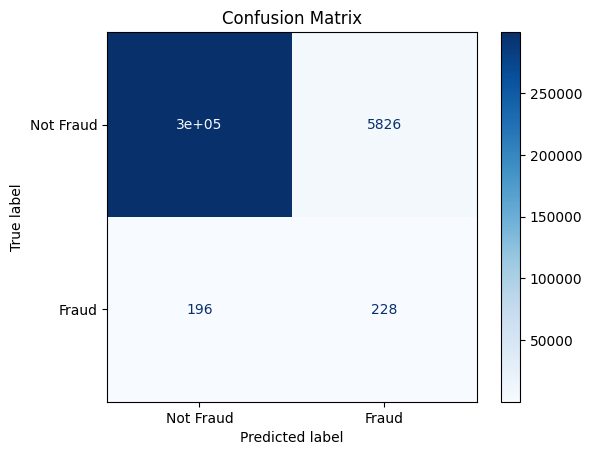

Recall: 0.5377
F1-Score: 0.0704


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score, f1_score
import matplotlib.pyplot as plt

# 1. Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 2. 혼동 행렬
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
print("\nConfusion Matrix:")
print(cm)

# 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# 3. Recall 및 F1-Score
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.60      0.75    305261
           1       0.00      0.58      0.00       424

    accuracy                           0.60    305685
   macro avg       0.50      0.59      0.38    305685
weighted avg       1.00      0.60      0.75    305685



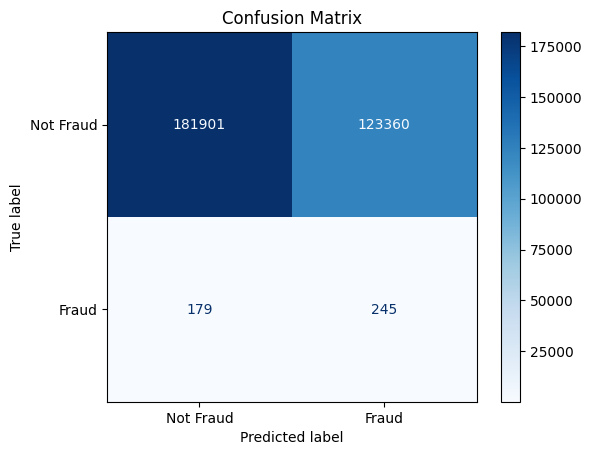

ROC-AUC Score: 0.6090
Optimal Threshold: 0.8161
Classification Report (Optimal Threshold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    305261
           1       0.01      0.03      0.02       424

    accuracy                           1.00    305685
   macro avg       0.51      0.51      0.51    305685
weighted avg       1.00      1.00      1.00    305685



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_recall_curve

# 1. Logistic Regression 학습
logistic_model = LogisticRegression(random_state=42, max_iter=500)
logistic_model.fit(X_train_balanced, y_train_balanced)

# 2. 예측 및 확률
y_pred = logistic_model.predict(X_test)
y_prob = logistic_model.predict_proba(X_test)[:, 1]

# 3. Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 4. Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# 5. ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# 6. Optimal Threshold Tuning
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = f1_scores.argmax()
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.4f}")

# 새로운 임계값 적용
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)

# 최적 임계값 결과 출력
print("Classification Report (Optimal Threshold):")
print(classification_report(y_test, y_pred_optimal))
